使用带有最近邻差值的上采样层的卷积自编码器生成QuickDraw数据
===

In [2]:
import os
import time

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

(28, 28)


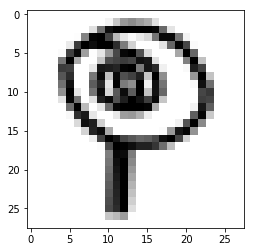

In [3]:
DATA_ROOT = os.path.join("/input/QuickDraw")

df = pd.read_csv(os.path.join(DATA_ROOT, 'quickdraw_png_set1_train.csv'), index_col=0)
df.head()

main_dir = os.path.join(DATA_ROOT, 'images/')

img = Image.open(os.path.join(main_dir, df.index[99]))
img = np.asarray(img, dtype=np.uint8)
print(img.shape)
plt.imshow(np.array(img), cmap='binary')

# 1.导入数据集

In [4]:
class QuickdrawDataset(Dataset):
    """Custom Dataset for loading Quickdraw images"""

    def __init__(self, txt_path, img_dir, transform=None):
    
        df = pd.read_csv(txt_path, sep=",", index_col=0)
        self.img_dir = img_dir
        self.txt_path = txt_path
        self.img_names = df.index.values
        self.y = df['Label'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[index]
        return img, label

    def __len__(self):
        return self.y.shape[0]

In [5]:
BATCH_SIZE = 128

custom_transform = transforms.Compose([#transforms.Lambda(lambda x: x/255.),
                                       transforms.ToTensor()])

train_dataset = QuickdrawDataset(txt_path=os.path.join(DATA_ROOT, 'quickdraw_png_set1_train.csv'),
                                 img_dir=main_dir,
                                 transform=custom_transform)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=4) 

# 2.设置

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)

# Hyperparameters
random_seed = 123
learning_rate = 0.0005
num_epochs = 50

Device: cuda:0


# 3.模型

In [7]:
class Autoencoder(torch.nn.Module):

    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # calculate same padding:
        # (w - k + 2*p)/s + 1 = o
        # => p = (s(o-1) - w + k)/2
        
        ### ENCODER
        
        # 28x28x1 => 28x28x4
        self.conv_1 = torch.nn.Conv2d(in_channels=1,
                                      out_channels=4,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      # (1(28-1) - 28 + 3) / 2 = 1
                                      padding=1)
        # 28x28x4 => 14x14x4                              
        self.pool_1 = torch.nn.MaxPool2d(kernel_size=(2, 2),
                                         stride=(2, 2),
                                         # (2(14-1) - 28 + 2) / 2 = 0
                                         padding=0)                                       
        # 14x14x4 => 14x14x8
        self.conv_2 = torch.nn.Conv2d(in_channels=4,
                                      out_channels=8,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      # (1(14-1) - 14 + 3) / 2 = 1
                                      padding=1)                 
        # 14x14x8 => 7x7x8                             
        self.pool_2 = torch.nn.MaxPool2d(kernel_size=(2, 2),
                                         stride=(2, 2),
                                         # (2(7-1) - 14 + 2) / 2 = 0
                                         padding=0)
        
        ### DECODER
                                         
        # 7x7x8 => 14x14x8                          
        
        ## interpolation
        
        # 14x14x8 => 14x14x8
        self.conv_3 = torch.nn.Conv2d(in_channels=8,
                                      out_channels=4,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      # (1(14-1) - 14 + 3) / 2 = 1
                                      padding=1)
        # 14x14x4 => 28x28x4                            

        ## interpolation
        
        # 28x28x4 => 28x28x1
        self.conv_4 = torch.nn.Conv2d(in_channels=4,
                                      out_channels=1,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      # (1(28-1) - 28 + 3) / 2 = 1
                                      padding=1)
        
    def forward(self, x):
        
        ### ENCODER
        x = self.conv_1(x)
        x = F.leaky_relu(x)
        x = self.pool_1(x)
        x = self.conv_2(x)
        x = F.leaky_relu(x)
        x = self.pool_2(x)
        
        ### DECODER
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = self.conv_3(x)
        x = F.leaky_relu(x)
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = self.conv_4(x)
        x = F.leaky_relu(x)
        x = torch.sigmoid(x)
        return x

    
torch.manual_seed(random_seed)
model = Autoencoder()
model = model.to(device)
    

##########################
### COST AND OPTIMIZER
##########################

cost_fn = torch.nn.BCELoss() # torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 4.训练

In [8]:
epoch_start = 1

torch.manual_seed(random_seed)
model = Autoencoder()
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

################## Load previous
# the code saves the autoencoder
# after each epoch so that in case
# the training process gets interrupted,
# we will not have to start training it
# from scratch
files = os.listdir()

start_time = time.time()
for epoch in range(epoch_start, num_epochs+1):
    
    
    for batch_idx, (x, y) in enumerate(train_loader):

        # don't need labels, only the images (features)
        features = x.to(device)
        
        ### FORWARD AND BACK PROP
        decoded = model(features)
        cost = F.mse_loss(decoded, features)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 500:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                   %(epoch, num_epochs, batch_idx, 
                     len(train_loader), cost))

        
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
        
# Save model
if os.path.isfile('autoencoder_quickdraw-1_i_%d_%s.pt' % (epoch-1, device)):
    os.remove('autoencoder_quickdraw-1_i_%d_%s.pt' % (epoch-1, device))
torch.save(model.state_dict(), 'autoencoder_quickdraw-1_i_%d_%s.pt' % (epoch, device))

Epoch: 001/050 | Batch 0000/8290 | Cost: 0.2220
Epoch: 001/050 | Batch 0500/8290 | Cost: 0.1009
Epoch: 001/050 | Batch 1000/8290 | Cost: 0.0700
Epoch: 001/050 | Batch 1500/8290 | Cost: 0.0647
Epoch: 001/050 | Batch 2000/8290 | Cost: 0.0526
Epoch: 001/050 | Batch 2500/8290 | Cost: 0.0413
Epoch: 001/050 | Batch 3000/8290 | Cost: 0.0405
Epoch: 001/050 | Batch 3500/8290 | Cost: 0.0400
Epoch: 001/050 | Batch 4000/8290 | Cost: 0.0372
Epoch: 001/050 | Batch 4500/8290 | Cost: 0.0355
Epoch: 001/050 | Batch 5000/8290 | Cost: 0.0344
Epoch: 001/050 | Batch 5500/8290 | Cost: 0.0319
Epoch: 001/050 | Batch 6000/8290 | Cost: 0.0325
Epoch: 001/050 | Batch 6500/8290 | Cost: 0.0317
Epoch: 001/050 | Batch 7000/8290 | Cost: 0.0301
Epoch: 001/050 | Batch 7500/8290 | Cost: 0.0299
Epoch: 001/050 | Batch 8000/8290 | Cost: 0.0314
Time elapsed: 1.67 min
Epoch: 002/050 | Batch 0000/8290 | Cost: 0.0309
Epoch: 002/050 | Batch 0500/8290 | Cost: 0.0311
Epoch: 002/050 | Batch 1000/8290 | Cost: 0.0264
Epoch: 002/050 | 

Epoch: 010/050 | Batch 7000/8290 | Cost: 0.0197
Epoch: 010/050 | Batch 7500/8290 | Cost: 0.0202
Epoch: 010/050 | Batch 8000/8290 | Cost: 0.0196
Time elapsed: 16.40 min
Epoch: 011/050 | Batch 0000/8290 | Cost: 0.0218
Epoch: 011/050 | Batch 0500/8290 | Cost: 0.0210
Epoch: 011/050 | Batch 1000/8290 | Cost: 0.0232
Epoch: 011/050 | Batch 1500/8290 | Cost: 0.0217
Epoch: 011/050 | Batch 2000/8290 | Cost: 0.0204
Epoch: 011/050 | Batch 2500/8290 | Cost: 0.0194
Epoch: 011/050 | Batch 3000/8290 | Cost: 0.0194
Epoch: 011/050 | Batch 3500/8290 | Cost: 0.0206
Epoch: 011/050 | Batch 4000/8290 | Cost: 0.0201
Epoch: 011/050 | Batch 4500/8290 | Cost: 0.0192
Epoch: 011/050 | Batch 5000/8290 | Cost: 0.0206
Epoch: 011/050 | Batch 5500/8290 | Cost: 0.0190
Epoch: 011/050 | Batch 6000/8290 | Cost: 0.0218
Epoch: 011/050 | Batch 6500/8290 | Cost: 0.0183
Epoch: 011/050 | Batch 7000/8290 | Cost: 0.0180
Epoch: 011/050 | Batch 7500/8290 | Cost: 0.0221
Epoch: 011/050 | Batch 8000/8290 | Cost: 0.0187
Time elapsed: 18

Epoch: 020/050 | Batch 5000/8290 | Cost: 0.0180
Epoch: 020/050 | Batch 5500/8290 | Cost: 0.0201
Epoch: 020/050 | Batch 6000/8290 | Cost: 0.0178
Epoch: 020/050 | Batch 6500/8290 | Cost: 0.0182
Epoch: 020/050 | Batch 7000/8290 | Cost: 0.0184
Epoch: 020/050 | Batch 7500/8290 | Cost: 0.0196
Epoch: 020/050 | Batch 8000/8290 | Cost: 0.0178
Time elapsed: 32.66 min
Epoch: 021/050 | Batch 0000/8290 | Cost: 0.0188
Epoch: 021/050 | Batch 0500/8290 | Cost: 0.0178
Epoch: 021/050 | Batch 1000/8290 | Cost: 0.0194
Epoch: 021/050 | Batch 1500/8290 | Cost: 0.0199
Epoch: 021/050 | Batch 2000/8290 | Cost: 0.0179
Epoch: 021/050 | Batch 2500/8290 | Cost: 0.0189
Epoch: 021/050 | Batch 3000/8290 | Cost: 0.0177
Epoch: 021/050 | Batch 3500/8290 | Cost: 0.0182
Epoch: 021/050 | Batch 4000/8290 | Cost: 0.0188
Epoch: 021/050 | Batch 4500/8290 | Cost: 0.0188
Epoch: 021/050 | Batch 5000/8290 | Cost: 0.0195
Epoch: 021/050 | Batch 5500/8290 | Cost: 0.0185
Epoch: 021/050 | Batch 6000/8290 | Cost: 0.0174
Epoch: 021/050 |

Epoch: 030/050 | Batch 3000/8290 | Cost: 0.0192
Epoch: 030/050 | Batch 3500/8290 | Cost: 0.0183
Epoch: 030/050 | Batch 4000/8290 | Cost: 0.0188
Epoch: 030/050 | Batch 4500/8290 | Cost: 0.0184
Epoch: 030/050 | Batch 5000/8290 | Cost: 0.0184
Epoch: 030/050 | Batch 5500/8290 | Cost: 0.0191
Epoch: 030/050 | Batch 6000/8290 | Cost: 0.0186
Epoch: 030/050 | Batch 6500/8290 | Cost: 0.0184
Epoch: 030/050 | Batch 7000/8290 | Cost: 0.0180
Epoch: 030/050 | Batch 7500/8290 | Cost: 0.0180
Epoch: 030/050 | Batch 8000/8290 | Cost: 0.0187
Time elapsed: 48.81 min
Epoch: 031/050 | Batch 0000/8290 | Cost: 0.0180
Epoch: 031/050 | Batch 0500/8290 | Cost: 0.0184
Epoch: 031/050 | Batch 1000/8290 | Cost: 0.0172
Epoch: 031/050 | Batch 1500/8290 | Cost: 0.0189
Epoch: 031/050 | Batch 2000/8290 | Cost: 0.0193
Epoch: 031/050 | Batch 2500/8290 | Cost: 0.0173
Epoch: 031/050 | Batch 3000/8290 | Cost: 0.0178
Epoch: 031/050 | Batch 3500/8290 | Cost: 0.0179
Epoch: 031/050 | Batch 4000/8290 | Cost: 0.0179
Epoch: 031/050 |

Epoch: 040/050 | Batch 1000/8290 | Cost: 0.0171
Epoch: 040/050 | Batch 1500/8290 | Cost: 0.0173
Epoch: 040/050 | Batch 2000/8290 | Cost: 0.0191
Epoch: 040/050 | Batch 2500/8290 | Cost: 0.0170
Epoch: 040/050 | Batch 3000/8290 | Cost: 0.0183
Epoch: 040/050 | Batch 3500/8290 | Cost: 0.0181
Epoch: 040/050 | Batch 4000/8290 | Cost: 0.0182
Epoch: 040/050 | Batch 4500/8290 | Cost: 0.0171
Epoch: 040/050 | Batch 5000/8290 | Cost: 0.0179
Epoch: 040/050 | Batch 5500/8290 | Cost: 0.0184
Epoch: 040/050 | Batch 6000/8290 | Cost: 0.0181
Epoch: 040/050 | Batch 6500/8290 | Cost: 0.0176
Epoch: 040/050 | Batch 7000/8290 | Cost: 0.0169
Epoch: 040/050 | Batch 7500/8290 | Cost: 0.0165
Epoch: 040/050 | Batch 8000/8290 | Cost: 0.0172
Time elapsed: 65.01 min
Epoch: 041/050 | Batch 0000/8290 | Cost: 0.0170
Epoch: 041/050 | Batch 0500/8290 | Cost: 0.0180
Epoch: 041/050 | Batch 1000/8290 | Cost: 0.0181
Epoch: 041/050 | Batch 1500/8290 | Cost: 0.0184
Epoch: 041/050 | Batch 2000/8290 | Cost: 0.0188
Epoch: 041/050 |

Epoch: 049/050 | Batch 8000/8290 | Cost: 0.0170
Time elapsed: 79.60 min
Epoch: 050/050 | Batch 0000/8290 | Cost: 0.0160
Epoch: 050/050 | Batch 0500/8290 | Cost: 0.0166
Epoch: 050/050 | Batch 1000/8290 | Cost: 0.0179
Epoch: 050/050 | Batch 1500/8290 | Cost: 0.0175
Epoch: 050/050 | Batch 2000/8290 | Cost: 0.0179
Epoch: 050/050 | Batch 2500/8290 | Cost: 0.0159
Epoch: 050/050 | Batch 3000/8290 | Cost: 0.0176
Epoch: 050/050 | Batch 3500/8290 | Cost: 0.0164
Epoch: 050/050 | Batch 4000/8290 | Cost: 0.0174
Epoch: 050/050 | Batch 4500/8290 | Cost: 0.0173
Epoch: 050/050 | Batch 5000/8290 | Cost: 0.0171
Epoch: 050/050 | Batch 5500/8290 | Cost: 0.0167
Epoch: 050/050 | Batch 6000/8290 | Cost: 0.0165
Epoch: 050/050 | Batch 6500/8290 | Cost: 0.0182
Epoch: 050/050 | Batch 7000/8290 | Cost: 0.0168
Epoch: 050/050 | Batch 7500/8290 | Cost: 0.0160
Epoch: 050/050 | Batch 8000/8290 | Cost: 0.0164
Time elapsed: 81.23 min
Total Training Time: 81.23 min


# 5.评估

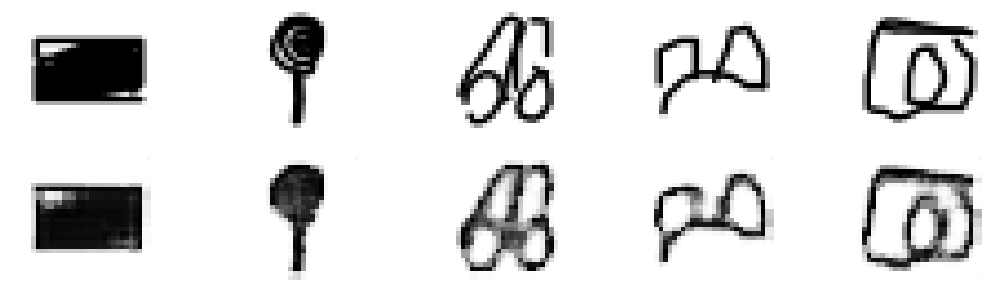

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt


model = Autoencoder()
model = model.to(device)
model.load_state_dict(torch.load('autoencoder_quickdraw-1_i_%d_%s.pt' % (num_epochs, device)))
model.eval()
torch.manual_seed(random_seed)

for batch_idx, (x, y) in enumerate(train_loader):
    features = x.to(device)
    decoded = model(features)
    break



##########################
### VISUALIZATION
##########################

n_images = 5

fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                         sharex=True, sharey=True, figsize=(18, 5))
orig_images = features.detach().cpu().numpy()[:n_images]
orig_images = np.moveaxis(orig_images, 1, -1)

decoded_images = decoded.detach().cpu().numpy()[:n_images]
decoded_images = np.moveaxis(decoded_images, 1, -1)


for i in range(n_images):
    for ax, img in zip(axes, [orig_images, decoded_images]):
        ax[i].axis('off')
        ax[i].imshow(img[i].reshape(28, 28), cmap='binary')